In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve

In [3]:

def bar(t, xc, b = 0.160, v = 1):

    if xc >=-b+v*t and xc <=b+v*t :
        return 1
    else: 
        return 0
    

In [4]:
def biphasic_alpha(t,tauOPL,tauOPL2,SF):
    
    kern =  (t/tauOPL**2) * np.exp(-t/tauOPL) * np.heaviside(t,1) -  SF* (t/tauOPL2**2) * np.exp(-t/tauOPL2) * np.heaviside(t,1) 
    # kern = (t/tauOPL) * np.exp(-t/tauOPL) * np.heaviside(t,1) -  SF* (t/tauOPL2) * np.exp(-t/tauOPL2) * np.heaviside(t,1) 
    # kern = kern/(np.sum(kern)*0.001)
    #calculate integral
    return  kern


tauOPLmono = 0.04
tauOPL = 0.08
tauOPL2 = 0.0876
SF = 1.

ftime = np.arange(0,1,0.001)
filter_mono = biphasic_alpha(ftime,tauOPLmono,1,0)
filter_mono = filter_mono/filter_mono.max()
filter_bi = biphasic_alpha(ftime,tauOPL,tauOPL2,SF)
filter_bi = filter_bi/filter_bi.max()

In [5]:
speeds = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0])

In [6]:
data = {}
cell = 150
# nets_list = ['Reciporcal_fitted/wBA/wBA_31.0',
#              'Reciporcal_fitted/noGCGainControl/wBA/wBA_31.0',
#              'Reciporcal_fitted_linear/wBA/wBA_31.0',
#              'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_31.0',
#              'Reciporcal_mono_linear/wBA/wBA_31.0',
#              'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_31.0',
#              'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_0.0',
#              'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_0.0',]
nets_list = ['Reciporcal_fitted/noGCGainControl/wBA/wBA_31.0',
             'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_31.0',
             'Reciporcal_mono_linear_heavy/noGCGainControl/wBA/wBA_31.0',
             'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_0.0',
             'Reciporcal_mono_linear_heavy/noGCGainControl/wBA/wBA_0.0',
             'Reciporcal_fitted/noGCGainControl/wBA/wBA_0.0',]

for net in nets_list:
    
    data[net] = {}

    bars = []
    tps_rf_GC_mid = []
    times = []

    Fs = []
    RBs = []
    RAs = []
    RGs = []

    peaks_RG = []
    peaks_RB = []
    peaks_drive = []

    amps_RB = []
    amps_RA = []
    amps_RG = []
    amps_drive = []

    ants_RB_drive = []
    ants_RB_bar = []

    ants_RG_drive = []
    ants_RG_bar = []
    ants_drive = []

    for s in speeds: 
        fp = f'/user/sebert/home/Documents/Simulations/motion/anticipation_1D/Reciporcal/{net}/smooth_{s}'
        with open(f'{fp}/out', 'rb') as handle:
            out = pickle.load(handle)    
            
        with open(f'{fp}/params', 'rb') as handle:
            paramsi = pickle.load(handle)
            
        duration = paramsi['duration']
        dt = paramsi['dt']
        time = np.arange(0,duration,dt) #- (paramsi['spacing']*cell)/paramsi['speed']#*1000#+45
        pos_cell = paramsi['pos_rf_GC_mid'][cell]
        barr = [bar(t,pos_cell, v = s) for t in time]
        tp_bar = paramsi['tps_rf_GC_mid'][cell]

        peak_RB = time[np.argmax(out['RB'][50,:])]
        peak_RG = time[np.argmax(out['RG'][:])]
        peak_drive = time[np.argmax(out['F'][:])]

        amp_RB = np.max(out['RB'][50,:])
        amp_RA = np.max(out['RA'][50,:])
        amp_RG = np.max(out['RG'][:])
        amp_drive = np.max(out['F'][:])

        


        # RAM
        ant_RB_drive =  peak_drive - peak_RB
        ant_RB_bar  =  tp_bar - peak_RB

        ant_RG_drive =  peak_drive - peak_RG
        ant_RG_bar =  tp_bar - peak_RG
    
        ant_drive =  tp_bar - peak_drive

        bars.append(barr)
        tps_rf_GC_mid.append(tp_bar)
        times.append(time)

        Fs.append(out['F'])
        RBs.append(out['RB'][50,:])
        RAs.append(out['RA'][50,:])
        RGs.append(out['RG'])

        peaks_RB.append(peak_RB)
        peaks_RG.append(peak_RG)
        peaks_drive.append(peak_drive)

        amps_RB.append(amp_RB)
        amps_RA.append(amp_RA)
        amps_RG.append(amp_RG)
        amps_drive.append(amp_drive)

        ants_RB_drive.append(ant_RB_drive)
        ants_RB_bar.append(ant_RB_bar)
        
        ants_RG_drive.append(ant_RG_drive)
        ants_RG_bar.append(ant_RG_bar)
        ants_drive.append(ant_drive)


    
    data[net]['peaks']={}
    data[net]['peaks']['RB'] = np.asarray(peaks_RB)
    data[net]['peaks']['RG'] = np.asarray(peaks_RG)
    data[net]['peaks']['drive'] =np.asarray( peaks_drive)  

    data[net]['amps']={}
    data[net]['amps']['RB'] = np.asarray(amps_RB)
    data[net]['amps']['RA'] = np.asarray(amps_RA)
    data[net]['amps']['RG'] = np.asarray(amps_RG)
    data[net]['amps']['drive'] =np.asarray( amps_drive)

    data[net]['ants'] ={}
    data[net]['ants']['RB_drive'] =np.asarray(ants_RB_drive)
    data[net]['ants']['RB_bar'] =np.asarray(ants_RB_bar)
    data[net]['ants']['RG_drive'] =np.asarray(ants_RG_drive)
    data[net]['ants']['RG_bar'] =np.asarray(ants_RG_bar)
    data[net]['ants']['drive'] =np.asarray(ants_drive)
    
    data[net]['RB'] = RBs
    data[net]['RA'] = RAs
    data[net]['RG'] = RGs
    data[net]['F'] = Fs


    data['bars'] = bars
    data['tps_rf_mid'] = np.asarray(tps_rf_GC_mid)
    data['times'] = times

# tp of bar at cell's rf center

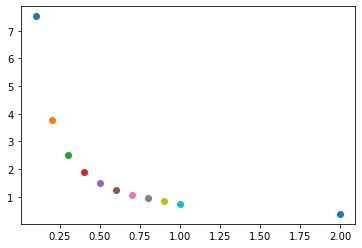

In [7]:
for i,s in enumerate(speeds):
    plt.scatter(s,data['tps_rf_mid'][i])

# scaling anticipation to bar  all versions

# 

IndexError: list index out of range

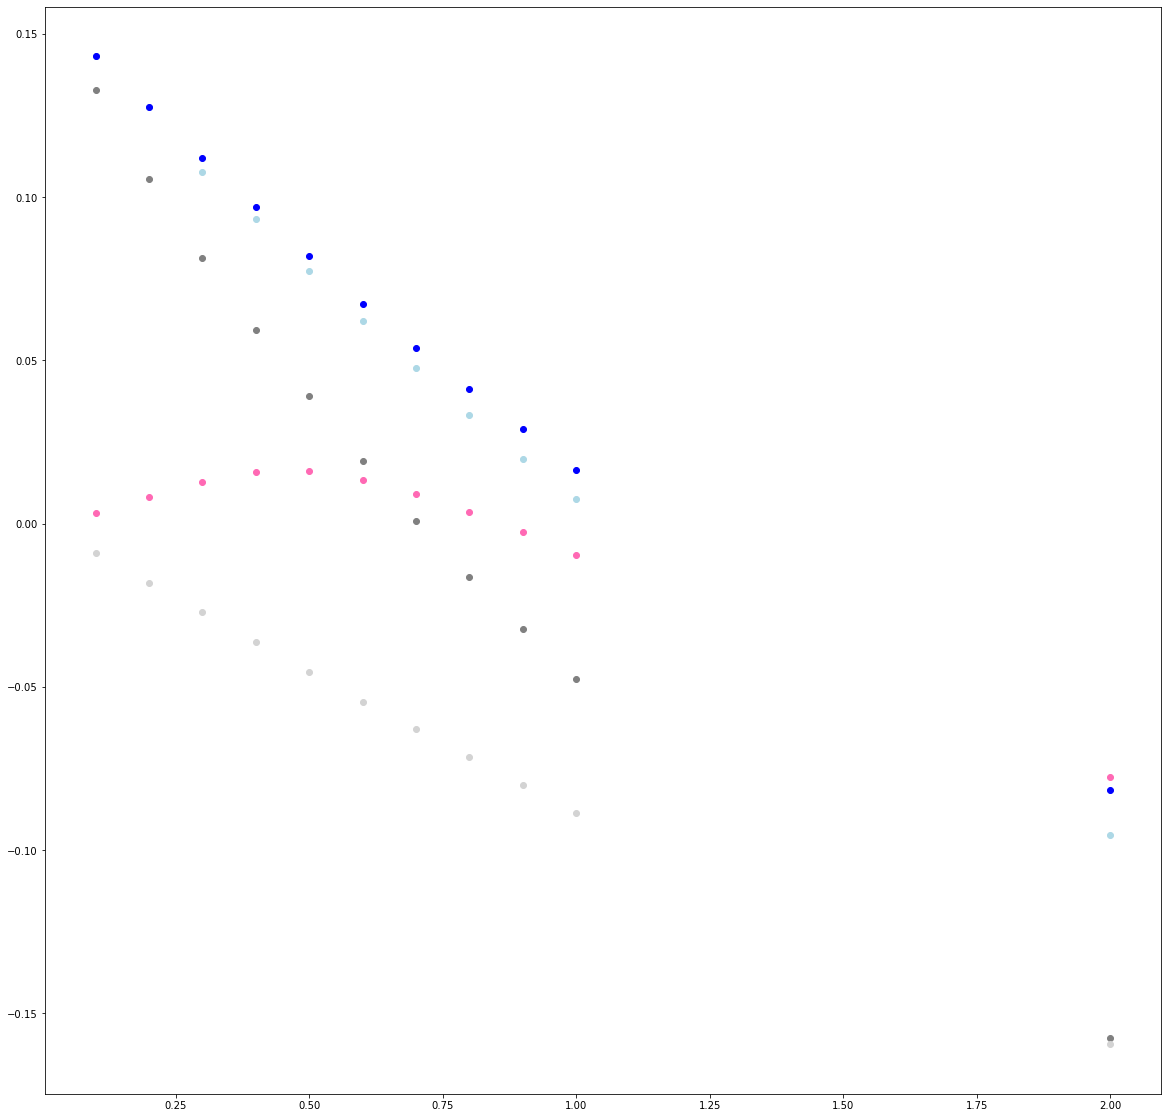

In [8]:
colors = ['lightblue', 'blue','hotpink', 'grey', 'lightgrey']

plt.figure(figsize =(20,20))
for i,net in enumerate(nets_list):
    # print(data[net]['ants']['RB_drive'])
    antis = np.array(data[net]['ants']['RG_bar'])*speeds 
    plt.scatter(speeds,antis, color = colors[i],label = net)

plt.axhline(0, color = 'grey', linestyle = ':')
plt.axvline(1, color = 'grey', linestyle = ':')
plt.xscale('log')
plt.legend()

## compare anticipation to v_drive vs bar  biphasic

In [9]:
for i in range(len(speeds)):
    print(np.max(data[net]['RA'][i]))

24.02789226125318
74.74489237475524
104.83534446687915
122.12249027304266
131.94542174090193
137.6047439564371
140.86709478018625
142.49574439585155
142.78230131615257
141.7432425655291
99.0564367018256


Text(0, 0.5, 'anticipation [mm]')

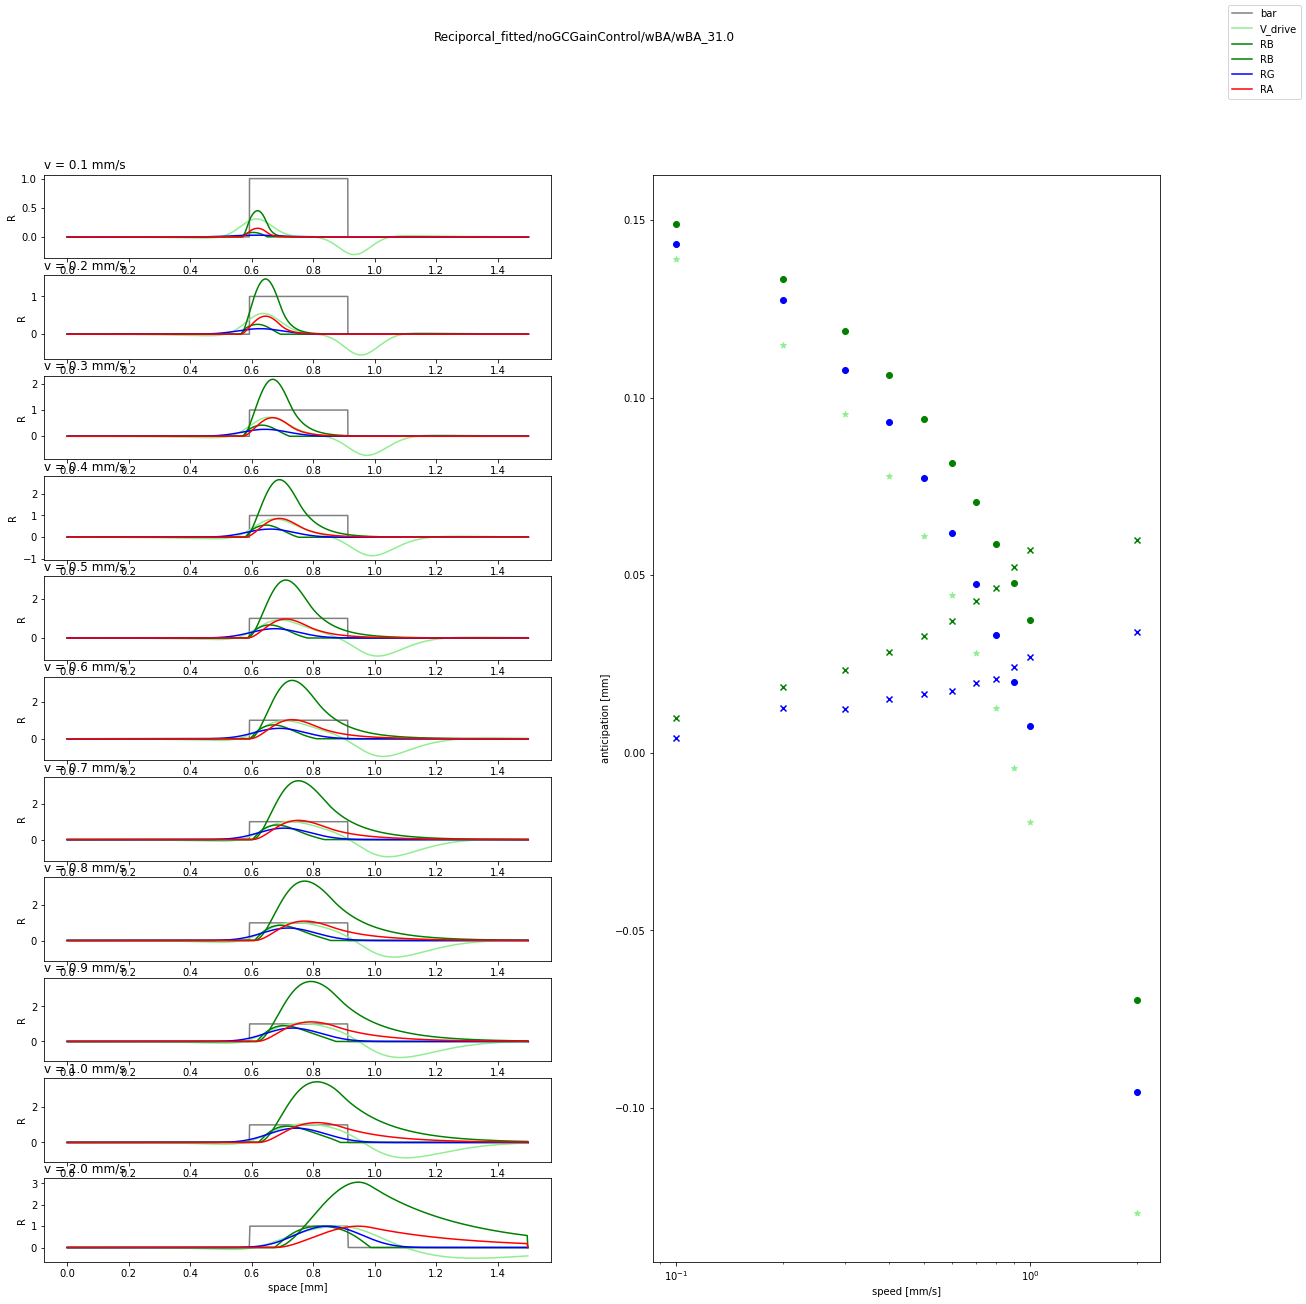

In [10]:
fig = plt.figure(figsize = (20,20))
gs = fig.add_gridspec(len(speeds),2)

net = nets_list[0]
for i,s in enumerate(speeds):
    
    #title
    if i == 0:
        ax = fig.add_subplot(gs[i,0])
    else:
        ax = fig.add_subplot(gs[i,0], sharex = ax)
        
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    ax.plot(data['times'][i]*s,data['bars'][i], label = f'bar', color = 'grey')

    # plot drive 
    ax.plot(data['times'][i]*s,data[net]['F'][i]/np.max(data[net]['F'][-1]), label = f'V_drive', color = 'lightgreen')

    # plot RB
    ax.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB', color = 'green')
    ax.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RB'][-1]), label = f'RB', color = 'green')

    # plot RG
    ax.plot(data['times'][i]*s,data[net]['RG'][i]/np.max(data[net]['RG'][-1]), label = f'RG', color = 'blue')
    ax.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')
    if i ==0 :
        fig.legend()

    ax.set_xlabel('space [mm]')
    ax.set_ylabel('R')
fig.suptitle(f'{net}')

an = fig.add_subplot(gs[:,1])  
an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'green')
an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'blue')
an.scatter(speeds, data[net]['ants']['RB_drive']*speeds,marker= 'x', color = 'green')
an.scatter(speeds, data[net]['ants']['RG_drive']*speeds,marker= 'x',  color = 'blue')
an.scatter(speeds, data[net]['ants']['drive']*speeds,marker= '*',  color = 'lightgreen')
an.set_xscale('log')
an.set_xlabel('speed [mm/s]')
an.set_ylabel('anticipation [mm]')

# anticipation  to v drive vs bar monophasic

In [11]:
for i in range(len(speeds)):
    print(np.max(data[net]['RA'][i]))

6.205792064146389
20.176068651310437
29.949906971934876
36.498659901075364
40.75764774332079
43.514518826841744
45.30287899719292
46.43496456098553
47.15654470109071
47.571249011363015
42.20454955417171


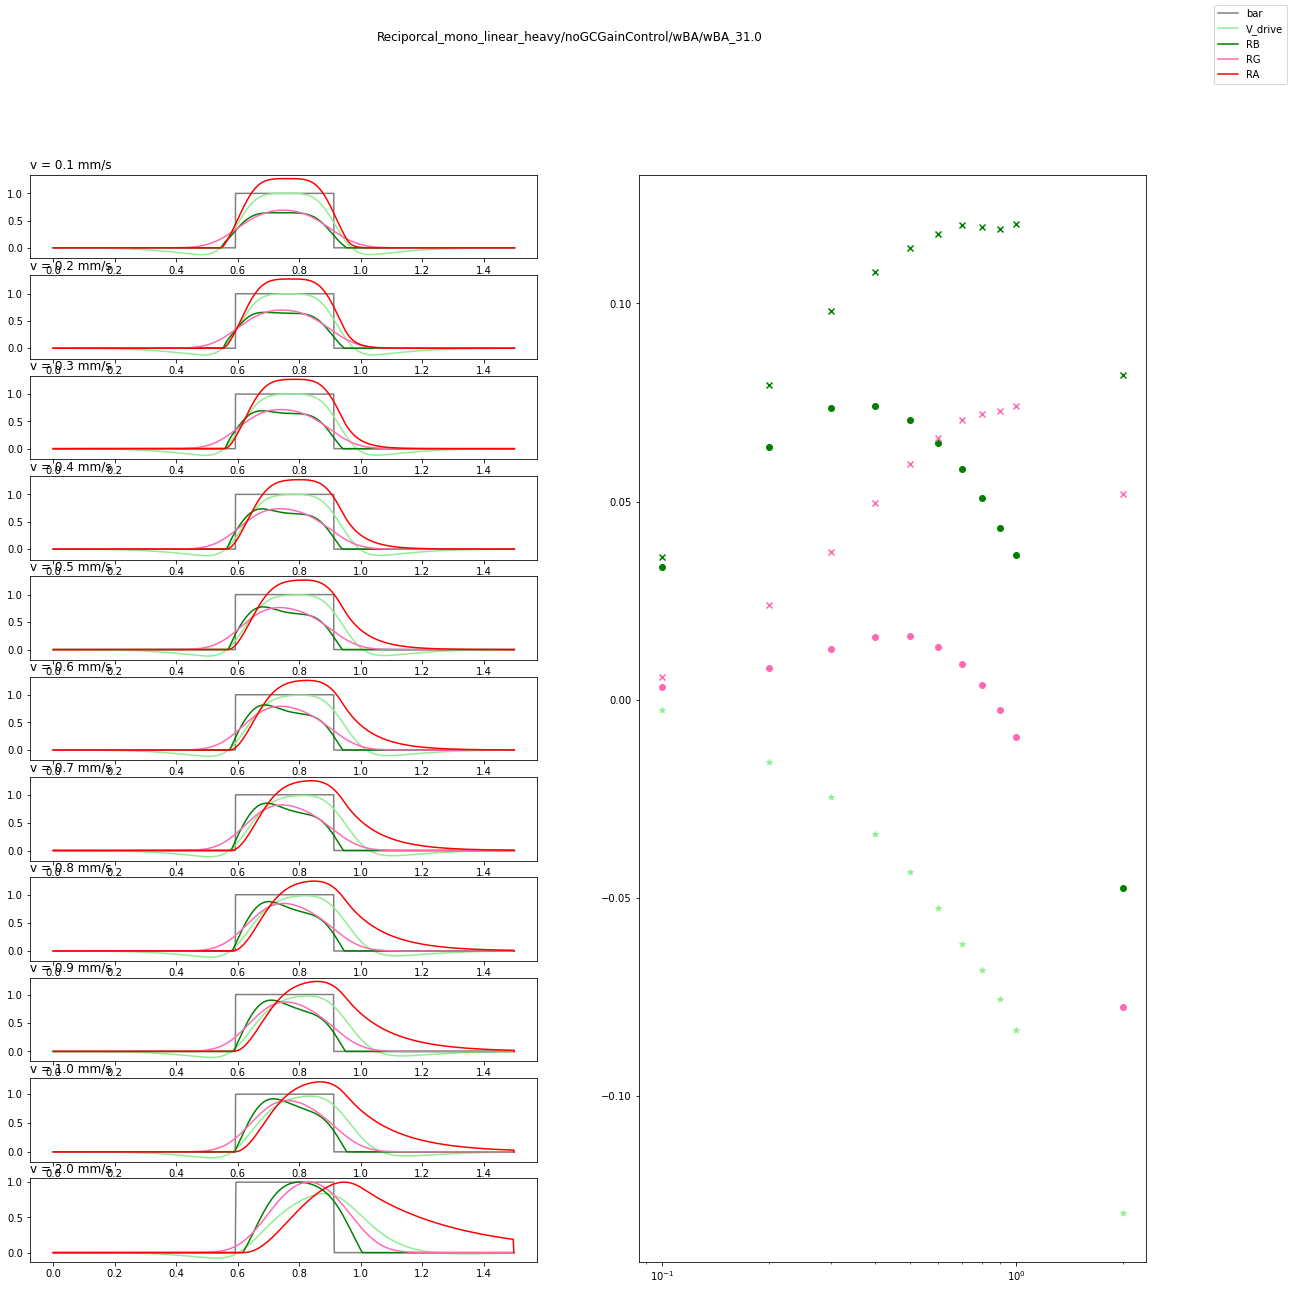

In [12]:
fig = plt.figure(figsize = (20,20))
gs = fig.add_gridspec(len(speeds),2)

net = nets_list[2]
for i,s in enumerate(speeds):
    
    #title
    if i == 0:
        ax = fig.add_subplot(gs[i,0])
    else:
        ax = fig.add_subplot(gs[i,0], sharex = ax)
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    ax.plot(data['times'][i]*s,data['bars'][i], label = f'bar', color = 'grey')

    # plot drive 
    ax.plot(data['times'][i]*s,data[net]['F'][i]/np.max(data[net]['F'][0]), label = f'V_drive', color = 'lightgreen')

    # plot RB
    ax.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB', color = 'green')

    # plot RG
    ax.plot(data['times'][i]*s,data[net]['RG'][i]/np.max(data[net]['RG'][-1]), label = f'RG', color = 'hotpink')
    ax.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')
    if i ==0 :
        fig.legend()


    

fig.suptitle(f'{net}')

an = fig.add_subplot(gs[:,1])  
an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'green')
an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'hotpink')
an.scatter(speeds, data[net]['ants']['RB_drive']*speeds,marker= 'x', color = 'green')
an.scatter(speeds, data[net]['ants']['RG_drive']*speeds,marker= 'x',  color = 'hotpink')
an.scatter(speeds, data[net]['ants']['drive']*speeds,marker= '*',  color = 'lightgreen')
an.set_xscale('log')

# Compare biphasic and monophasic V_drive

In [13]:
def normalize(vals):
    vals = np.asarray(vals)
    return (vals-np.mean(vals))/np.std(vals)


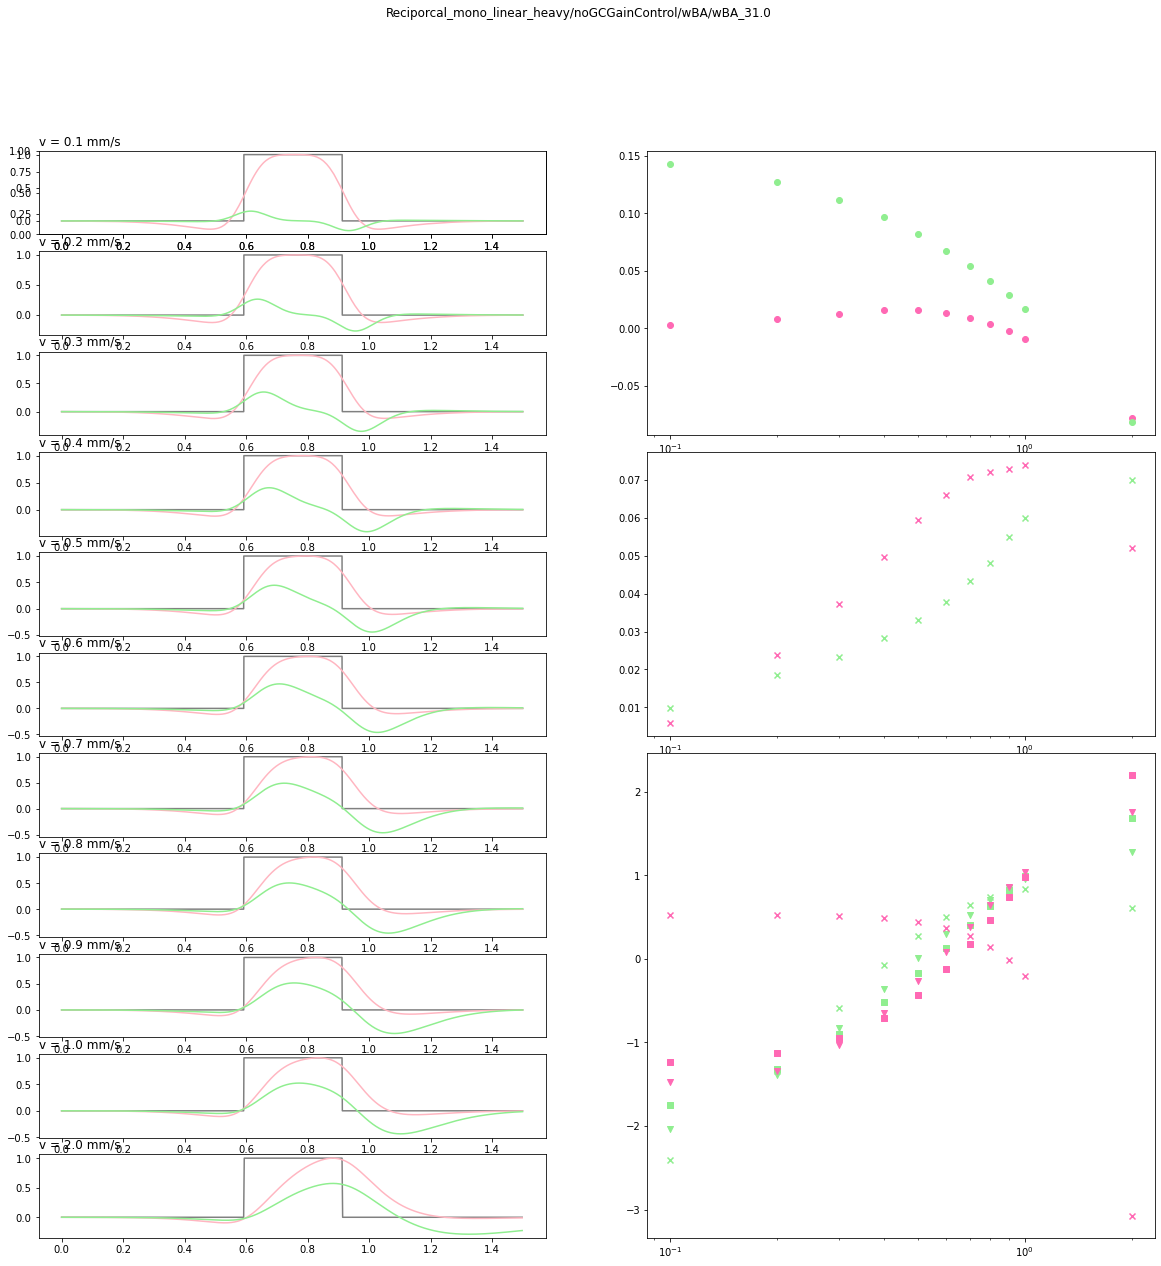

In [14]:
fig = plt.figure(figsize = (20,20))
gs = fig.add_gridspec(len(speeds),2)

net_mono = nets_list[2]
net_bi = nets_list[1]
for i,s in enumerate(speeds):
    
    #title
    if i == 0:
        ax = fig.add_subplot(gs[i,0])
    ax = fig.add_subplot(gs[i,0], sharex = ax)
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    ax.plot(data['times'][i]*s,data['bars'][i], label = f'bar', color = 'grey')

    # plot drive 
    ax.plot(data['times'][i]*s,data[net_mono]['F'][i]/np.max(data[net]['F'][i]), label = f'V_drive mono', color = 'lightpink')
    ax.plot(data['times'][i]*s,data[net_bi]['F'][i]/np.max(data[net]['F'][i]), label = f'V_drive bi', color = 'lightgreen')

    # plot RB
    # ax.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][i]), label = f'RB', color = 'green')

    # # plot RG
    # ax.plot(data['times'][i]*s,data[net]['RG'][i]/np.max(data[net]['RG'][i]), label = f'RG', color = 'hotpink')
    # if i ==0 :
    #     fig.legend()




fig.suptitle(f'{net}')

anb = fig.add_subplot(gs[:3,1])  
andr = fig.add_subplot(gs[3:6,1])
amp = fig.add_subplot(gs[6:,1])

anb.scatter(speeds, data[net_mono]['ants']['RG_bar']*speeds, color = 'hotpink')
anb.scatter(speeds, data[net_bi]['ants']['RG_bar']*speeds, color = 'lightgreen')

andr.scatter(speeds, data[net_bi]['ants']['RB_drive']*speeds,marker= 'x', color = 'lightgreen')
andr.scatter(speeds, data[net_mono]['ants']['RG_drive']*speeds,marker= 'x',  color = 'hotpink')

amp.scatter(speeds, normalize(data[net_bi]['amps']['RB']),marker= 'v', color = 'lightgreen')
amp.scatter(speeds, normalize(data[net_bi]['amps']['RG']),marker= 's',  color = 'lightgreen')
amp.scatter(speeds, normalize(data[net_bi]['amps']['drive']),marker= 'x',  color = 'lightgreen')

amp.scatter(speeds, normalize(data[net_mono]['amps']['RB']),marker= 'v', color = 'hotpink')
amp.scatter(speeds, normalize(data[net_mono]['amps']['RG']),marker= 's',  color = 'hotpink')
amp.scatter(speeds, normalize(data[net_mono]['amps']['drive']),marker= 'x',  color = 'hotpink')


anb.set_xscale('log')
andr.set_xscale('log')
amp.set_xscale('log')

# Mechanism Speedscaling RAM 

In [15]:
speeds

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 2. ])

Text(0, 0.5, 'anticipation [mm]')

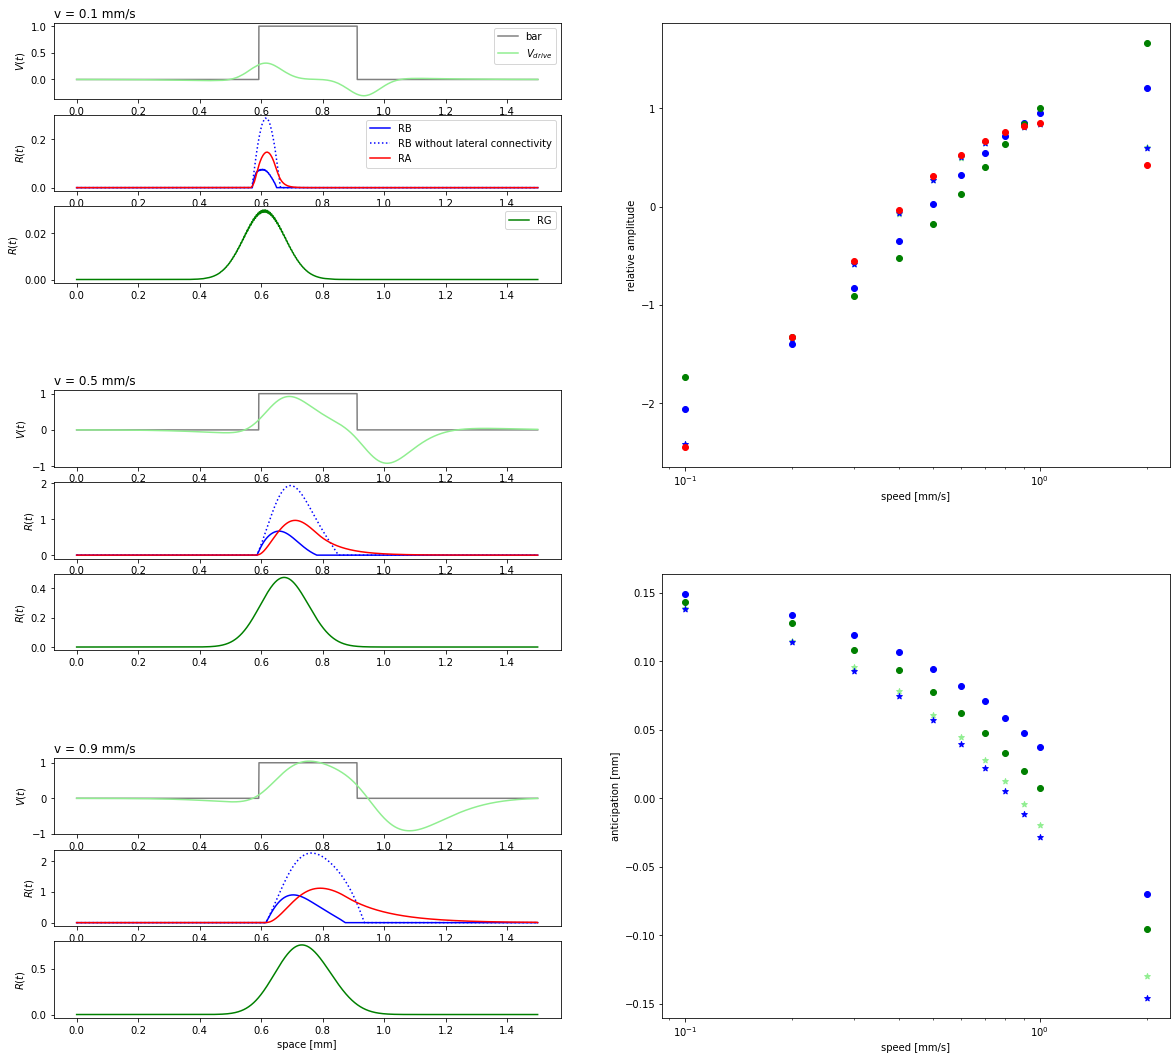

In [16]:
speeds_plot = [0.1,0.5,0.9]
speeds_plot_idx = [0,4,8]

fig = plt.figure(figsize = (20,20))
gs = fig.add_gridspec(len(speeds_plot)*4,2)



net = nets_list[0]
net_pool = nets_list[-1]
for x,s in enumerate(speeds_plot):
    i = speeds_plot_idx[x]
    #title
    if i == 0:
        ax = fig.add_subplot(gs[4*x,0])
        ax2 = fig.add_subplot(gs[4*x+1,0])
        ax3 = fig.add_subplot(gs[4*x+2,0])
    else:
        ax = fig.add_subplot(gs[4*x,0], sharex = ax)
        ax2 = fig.add_subplot(gs[4*x+1,0], sharex = ax)
        ax3 = fig.add_subplot(gs[4*x+2,0], sharex = ax)
      
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    ax.plot(data['times'][i]*s,data['bars'][i], label = f'bar', color = 'grey')

    # plot drive 
    ax.plot(data['times'][i]*s,data[net]['F'][i]/np.max(data[net]['F'][-1]), label = '$V_{drive}$', color = 'lightgreen')

    # plot RB
    ax2.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB', color = 'blue')
    ax2.plot(data['times'][i]*s,data[net_pool]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB without lateral connectivity', color = 'blue', linestyle = ':')
    ax2.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')

    # plot RG
    ax3.plot(data['times'][i]*s,data[net]['RG'][i]/np.max(data[net]['RG'][-1]), label = f'RG', color = 'green')
    #ax.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')
    if i ==0 :
        ax.legend()
        ax2.legend()
        ax3.legend()

    if x ==2:
        ax3.set_xlabel('space [mm]')
    ax.set_ylabel('$V(t)$')
    ax2.set_ylabel('$R(t)$')
    ax3.set_ylabel('$R(t)$')
#fig.suptitle(f'{net}')



amp = fig.add_subplot(gs[:5,1])  
amp.scatter(speeds, normalize(data[net]['amps']['drive']),marker= '*',  color = 'lightgreen')
amp.scatter(speeds, normalize(data[net]['amps']['RB']), color = 'blue')
amp.scatter(speeds, normalize(data[net_pool]['amps']['RB']), color = 'blue', marker = '*')
amp.scatter(speeds, normalize(data[net]['amps']['RG']), color = 'green')
amp.scatter(speeds, normalize(data[net]['amps']['RA']), color = 'red')
amp.set_xscale('log')
amp.set_xlabel('speed [mm/s]')
amp.set_ylabel('relative amplitude')


an = fig.add_subplot(gs[6:-1,1])  
an.scatter(speeds, data[net]['ants']['drive']*speeds,marker= '*',  color = 'lightgreen')
an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'blue')
an.scatter(speeds, data[net_pool]['ants']['RB_bar']*speeds, color = 'blue', marker = '*')
an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'green')

an.set_xscale('log')
an.set_xlabel('speed [mm/s]')
an.set_ylabel('anticipation [mm]')

Text(0, 0.5, 'anticipation [mm]')

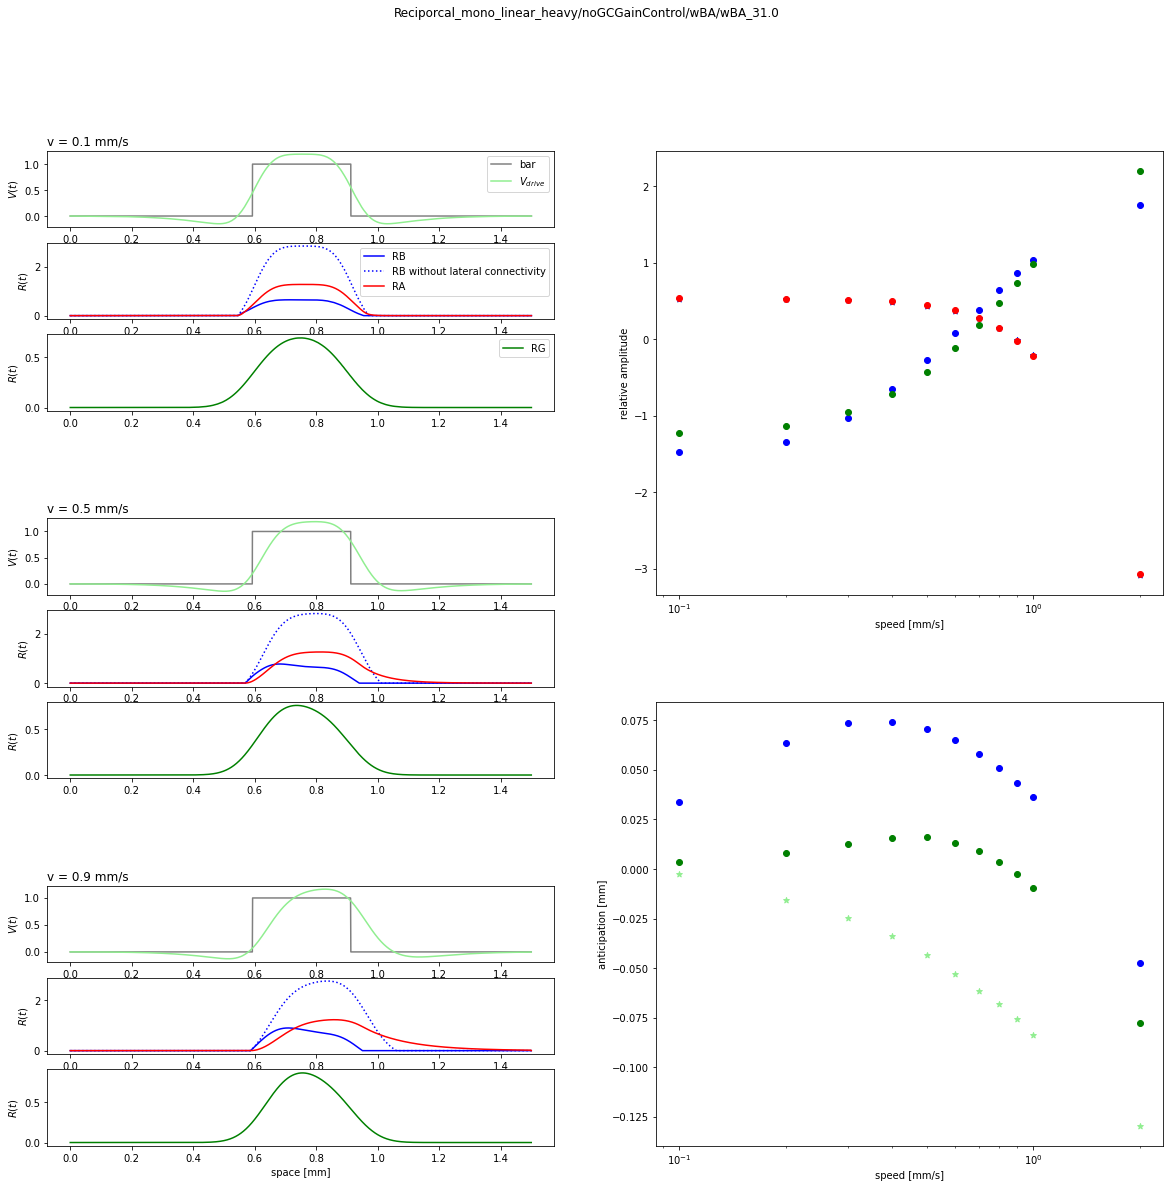

In [17]:
speeds_plot = [0.1,0.5,0.9]
speeds_plot_idx = [0,4,8]

fig = plt.figure(figsize = (20,20))
gs = fig.add_gridspec(len(speeds_plot)*4,2)



net = nets_list[2]
net_pool = nets_list[-2]
for x,s in enumerate(speeds_plot):
    i = speeds_plot_idx[x]
    #title
    if i == 0:
        ax = fig.add_subplot(gs[4*x,0])
        ax2 = fig.add_subplot(gs[4*x+1,0])
        ax3 = fig.add_subplot(gs[4*x+2,0])
    else:
        ax = fig.add_subplot(gs[4*x,0], sharex = ax)
        ax2 = fig.add_subplot(gs[4*x+1,0], sharex = ax)
        ax3 = fig.add_subplot(gs[4*x+2,0], sharex = ax)
      
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    ax.plot(data['times'][i]*s,data['bars'][i], label = f'bar', color = 'grey')

    # plot drive 
    ax.plot(data['times'][i]*s,data[net]['F'][i]/np.max(data[net]['F'][-1]), label = '$V_{drive}$', color = 'lightgreen')

    # plot RB
    ax2.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB', color = 'blue')
    ax2.plot(data['times'][i]*s,data[net_pool]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB without lateral connectivity', color = 'blue', linestyle = ':')
    ax2.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')

    # plot RG
    ax3.plot(data['times'][i]*s,data[net]['RG'][i]/np.max(data[net]['RG'][-1]), label = f'RG', color = 'green')
    #ax.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')
    if i ==0 :
        ax.legend()
        ax2.legend()
        ax3.legend()

    if x ==2:
        ax3.set_xlabel('space [mm]')
    ax.set_ylabel('$V(t)$')
    ax2.set_ylabel('$R(t)$')
    ax3.set_ylabel('$R(t)$')
fig.suptitle(f'{net}')



amp = fig.add_subplot(gs[:5,1])  
amp.scatter(speeds, normalize(data[net]['amps']['drive']),marker= '*',  color = 'lightgreen')
amp.scatter(speeds, normalize(data[net]['amps']['RB']), color = 'blue')
amp.scatter(speeds, normalize(data[net_pool]['amps']['RB']), color = 'blue', marker = '*')
amp.scatter(speeds, normalize(data[net]['amps']['RG']), color = 'green')
amp.scatter(speeds, normalize(data[net]['amps']['RA']), color = 'red')
amp.set_xscale('log')
amp.set_xlabel('speed [mm/s]')
amp.set_ylabel('relative amplitude')


an = fig.add_subplot(gs[6:-1,1])  
an.scatter(speeds, data[net]['ants']['drive']*speeds,marker= '*',  color = 'lightgreen')
an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'blue')
an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'green')

an.set_xscale('log')
an.set_xlabel('speed [mm/s]')
an.set_ylabel('anticipation [mm]')

# Biphasic Monophasic Speed scaling

Text(0, 0.5, 'anticipation [mm]')

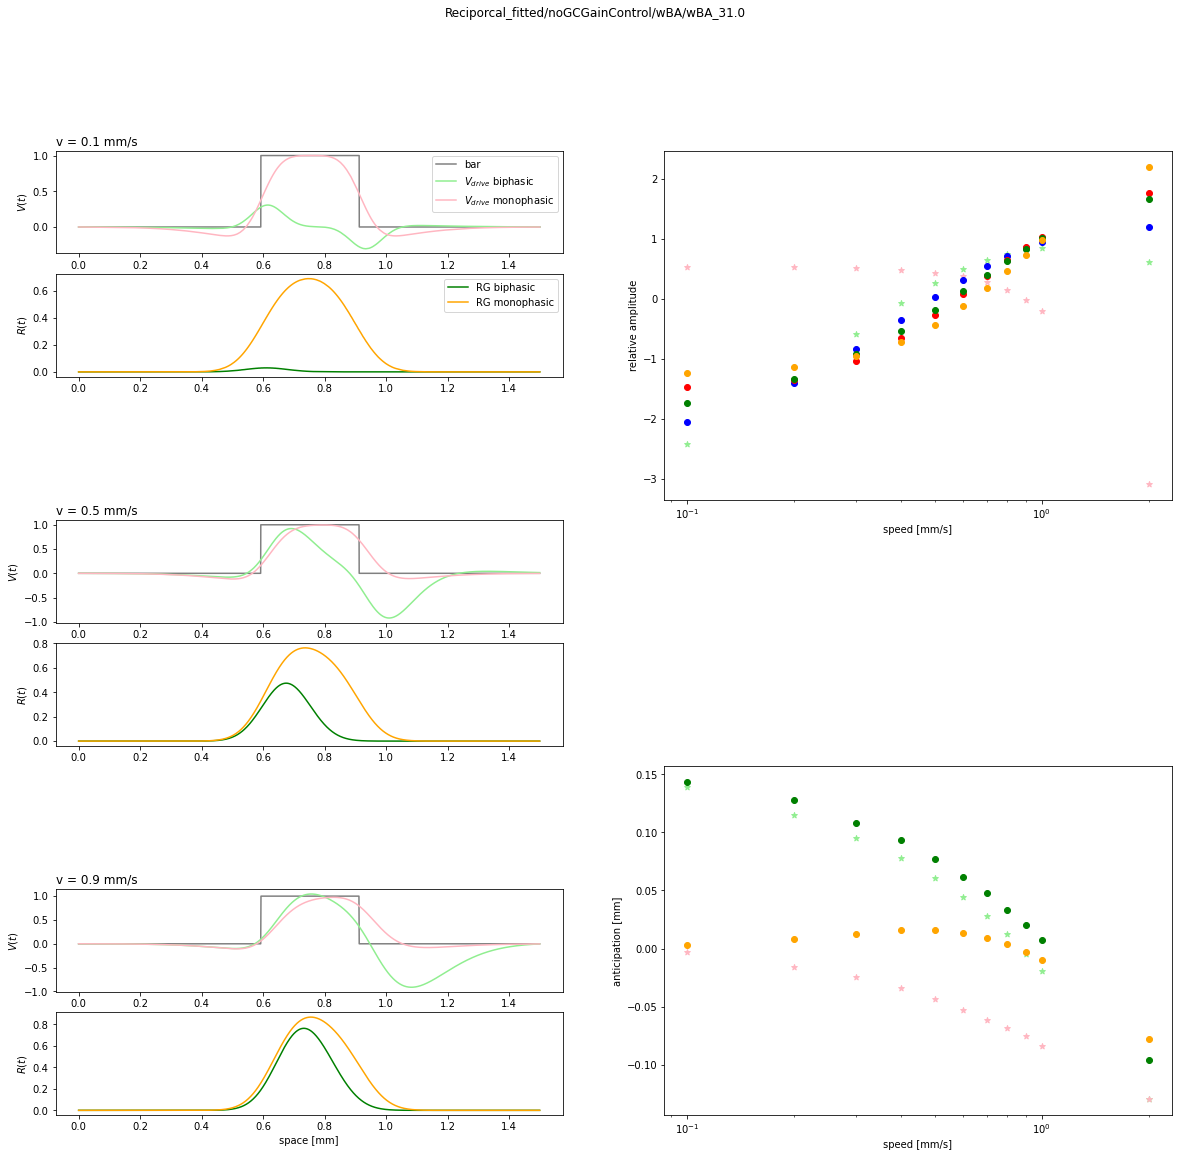

In [18]:
fig = plt.figure(figsize = (20,20))
gs = fig.add_gridspec(len(speeds_plot)*3,2)



net = nets_list[0]
net_mono = nets_list[2]
for x,s in enumerate(speeds_plot):
    i = speeds_plot_idx[x]
    #title
    if i == 0:
        ax = fig.add_subplot(gs[3*x,0])
        ax3 = fig.add_subplot(gs[3*x+1,0])
    else:
        ax = fig.add_subplot(gs[3*x,0], sharex = ax)
        ax3 = fig.add_subplot(gs[3*x+1,0], sharex = ax)
      
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    ax.plot(data['times'][i]*s,data['bars'][i], label = f'bar', color = 'grey')

    # plot drive 
    ax.plot(data['times'][i]*s,data[net]['F'][i]/np.max(data[net]['F'][-1]), label = '$V_{drive}$ biphasic', color = 'lightgreen')
    ax.plot(data['times'][i]*s,data[net_mono]['F'][i]/np.max(data[net_mono]['F'][0]), label = '$V_{drive}$ monophasic', color = 'lightpink')

    # # plot RB
    # ax2.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB', color = 'blue')
    # ax2.plot(data['times'][i]*s,data[net_pool]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB without lateral connectivity', color = 'blue', linestyle = ':')
    # ax2.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')

    # plot RG
    ax3.plot(data['times'][i]*s,data[net]['RG'][i]/np.max(data[net]['RG'][-1]), label = f'RG biphasic', color = 'green')
    ax3.plot(data['times'][i]*s,data[net_mono]['RG'][i]/np.max(data[net_mono]['RG'][-1]), label = f'RG monophasic', color = 'orange')
    #ax.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')
    if i ==0 :
        ax.legend()
        #ax2.legend()
        ax3.legend()

    if x ==2:
        ax3.set_xlabel('space [mm]')
    ax.set_ylabel('$V(t)$')
    ax2.set_ylabel('$R(t)$')
    ax3.set_ylabel('$R(t)$')
fig.suptitle(f'{net}')



amp = fig.add_subplot(gs[:3,1])  
amp.scatter(speeds, normalize(data[net]['amps']['drive']),marker= '*',  color = 'lightgreen')
amp.scatter(speeds, normalize(data[net_mono]['amps']['drive']),marker= '*',  color = 'lightpink')
amp.scatter(speeds, normalize(data[net]['amps']['RB']), color = 'blue')
amp.scatter(speeds, normalize(data[net_mono]['amps']['RB']), color = 'red')
amp.scatter(speeds, normalize(data[net]['amps']['RG']), color = 'green')
amp.scatter(speeds, normalize(data[net_mono]['amps']['RG']), color = 'orange')
#amp.scatter(speeds, normalize(data[net]['amps']['RA']), color = 'red')
amp.set_xscale('log')
amp.set_xlabel('speed [mm/s]')
amp.set_ylabel('relative amplitude')


an = fig.add_subplot(gs[5:-1,1])  
an.scatter(speeds, data[net]['ants']['drive']*speeds,marker= '*',  color = 'lightgreen')
an.scatter(speeds, data[net_mono]['ants']['drive']*speeds,marker= '*',  color = 'lightpink')
#an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'blue')
an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'green')
an.scatter(speeds, data[net_mono]['ants']['RG_bar']*speeds, color = 'orange')

an.set_xscale('log')
an.set_xlabel('speed [mm/s]')
an.set_ylabel('anticipation [mm]')

Text(0, 0.5, 'anticipation [mm]')

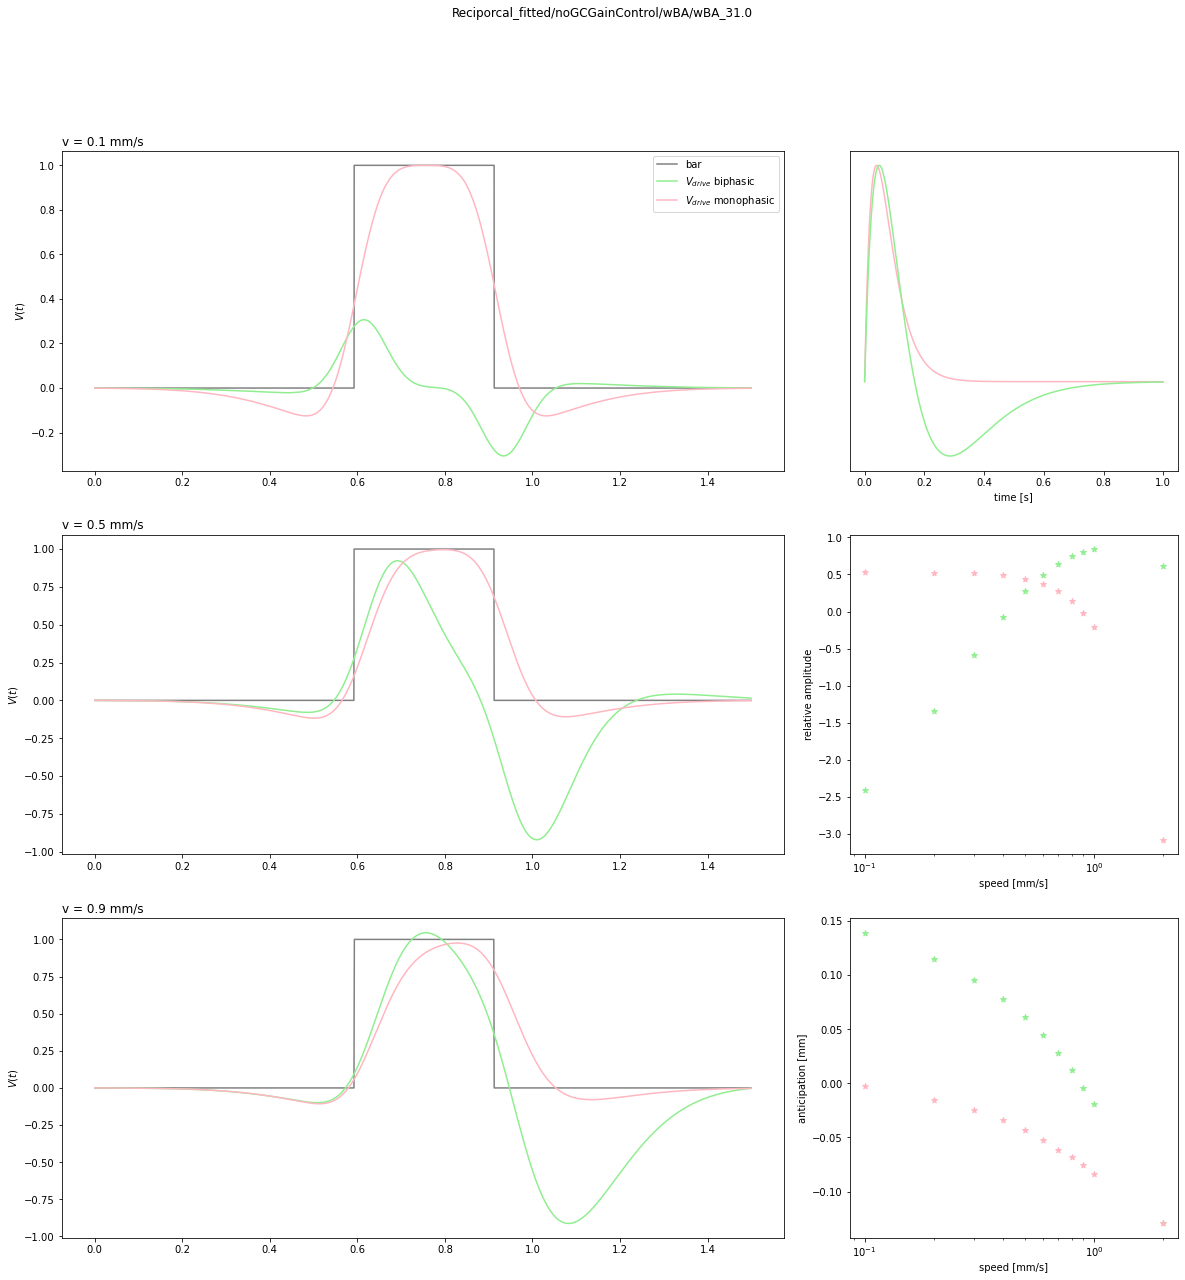

In [19]:
fig = plt.figure(figsize = (20,20))
gs = fig.add_gridspec(len(speeds_plot),3)



net = nets_list[0]
net_mono = nets_list[2]
for x,s in enumerate(speeds_plot):
    i = speeds_plot_idx[x]
    #title
    if i == 0:
        ax = fig.add_subplot(gs[x,:2])
    else:
        ax = fig.add_subplot(gs[x,:2], sharex = ax)
      
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    ax.plot(data['times'][i]*s,data['bars'][i], label = f'bar', color = 'grey')

    # plot drive 
    ax.plot(data['times'][i]*s,data[net]['F'][i]/np.max(data[net]['F'][-1]), label = '$V_{drive}$ biphasic', color = 'lightgreen')
    ax.plot(data['times'][i]*s,data[net_mono]['F'][i]/np.max(data[net_mono]['F'][0]), label = '$V_{drive}$ monophasic', color = 'lightpink')

    # # plot RB
    # ax2.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB', color = 'blue')
    # ax2.plot(data['times'][i]*s,data[net_pool]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB without lateral connectivity', color = 'blue', linestyle = ':')
    # ax2.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')

    # plot RG
    #ax.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')
    if i ==0 :
        ax.legend()

    ax.set_ylabel('$V(t)$')
fig.suptitle(f'{net}')




fil = fig.add_subplot(gs[0,2])
fil.plot(ftime,filter_mono, color ='lightpink')
fil.plot(ftime,filter_bi, color ='lightgreen')
fil.set_xlabel('time [s]')
fil.set_yticks([])
amp = fig.add_subplot(gs[1,2])  
amp.scatter(speeds, normalize(data[net]['amps']['drive']),marker= '*',  color = 'lightgreen')
amp.scatter(speeds, normalize(data[net_mono]['amps']['drive']),marker= '*',  color = 'lightpink')
# amp.scatter(speeds, normalize(data[net]['amps']['RB']), color = 'blue')
# amp.scatter(speeds, normalize(data[net_mono]['amps']['RB']), color = 'red')
# amp.scatter(speeds, normalize(data[net]['amps']['RG']), color = 'green')
# amp.scatter(speeds, normalize(data[net_mono]['amps']['RG']), color = 'orange')
#amp.scatter(speeds, normalize(data[net]['amps']['RA']), color = 'red')
amp.set_xscale('log')
amp.set_xlabel('speed [mm/s]')
amp.set_ylabel('relative amplitude')


an = fig.add_subplot(gs[2,2])  
an.scatter(speeds, data[net]['ants']['drive']*speeds,marker= '*',  color = 'lightgreen')
an.scatter(speeds, data[net_mono]['ants']['drive']*speeds,marker= '*',  color = 'lightpink')
#an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'blue')
# an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'green')
# an.scatter(speeds, data[net_mono]['ants']['RG_bar']*speeds, color = 'orange')

an.set_xscale('log')
an.set_xlabel('speed [mm/s]')
an.set_ylabel('anticipation [mm]')

# x-axis is time 

In [23]:
speeds

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 2. ])

Text(0, 0.5, 'anticipation [mm]')

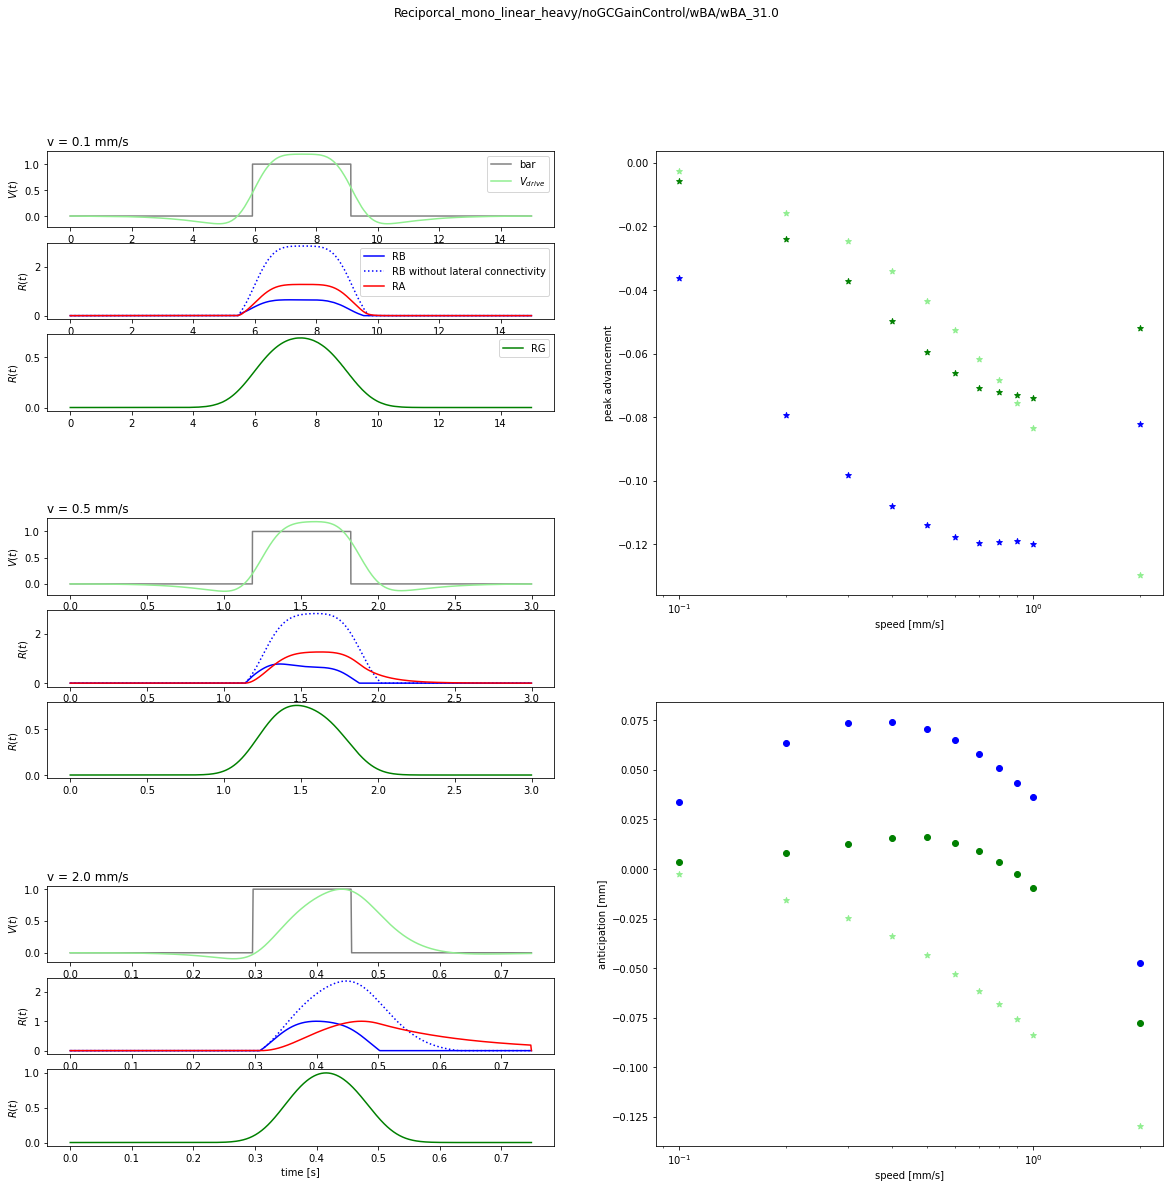

In [35]:
speeds_plot = [0.1,0.5,2.0]
speeds_plot_idx = [0,4,-1]
xlims = [(2,12),(1.2,3),(0.2,0.75)]

fig = plt.figure(figsize = (20,20))
gs = fig.add_gridspec(len(speeds_plot)*4,2)



net = nets_list[2]
net_pool = nets_list[-2]
for x,s in enumerate(speeds_plot):
    i = speeds_plot_idx[x]
    #title
    if i == 0:
        ax = fig.add_subplot(gs[4*x,0])
        ax2 = fig.add_subplot(gs[4*x+1,0], sharex = ax)
        ax3 = fig.add_subplot(gs[4*x+2,0], sharex = ax)
    else:
        ax = fig.add_subplot(gs[4*x,0])
        ax2 = fig.add_subplot(gs[4*x+1,0], sharex = ax)
        ax3 = fig.add_subplot(gs[4*x+2,0], sharex = ax)
      
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    ax.plot(data['times'][i],data['bars'][i], label = f'bar', color = 'grey')

    # plot drive 
    ax.plot(data['times'][i],data[net]['F'][i]/np.max(data[net]['F'][-1]), label = '$V_{drive}$', color = 'lightgreen')

    # plot RB
    ax2.plot(data['times'][i],data[net]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB', color = 'blue')
    ax2.plot(data['times'][i],data[net_pool]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB without lateral connectivity', color = 'blue', linestyle = ':')
    ax2.plot(data['times'][i],data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')

    # plot RG
    ax3.plot(data['times'][i],data[net]['RG'][i]/np.max(data[net]['RG'][-1]), label = f'RG', color = 'green')
    #ax.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')
    if i ==0 :
        ax.legend()
        ax2.legend()
        ax3.legend()


    if x ==2:
        ax3.set_xlabel('time [s]')
        #ax3.set_xlabel('space [mm]')
    ax.set_ylabel('$V(t)$')
    ax2.set_ylabel('$R(t)$')
    ax3.set_ylabel('$R(t)$')

    #ax.set_xlim(xlims[x])
fig.suptitle(f'{net}')



amp = fig.add_subplot(gs[:5,1])  
# amp.scatter(speeds, normalize(data[net]['amps']['drive']),marker= '*',  color = 'lightgreen')
# amp.scatter(speeds, normalize(data[net]['amps']['RB']), color = 'blue')
# amp.scatter(speeds, normalize(data[net_pool]['amps']['RB']), color = 'blue', marker = '*')
# amp.scatter(speeds, normalize(data[net]['amps']['RG']), color = 'green')
# amp.scatter(speeds, normalize(data[net]['amps']['RA']), color = 'red')
amp.scatter(speeds, data[net]['ants']['drive']*speeds,marker= '*',  color = 'lightgreen')

amp.scatter(speeds, data[net]['ants']['drive']*speeds - data[net]['ants']['RB_bar']*speeds, color = 'blue',marker = '*')
amp.scatter(speeds,  data[net]['ants']['drive']*speeds- data[net]['ants']['RG_bar']*speeds, color = 'green', marker = '*')

amp.set_xscale('log')
amp.set_xlabel('speed [mm/s]')
amp.set_ylabel('peak advancement')


an = fig.add_subplot(gs[6:-1,1])  
an.scatter(speeds, data[net]['ants']['drive']*speeds,marker= '*',  color = 'lightgreen')
an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'blue')
an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'green')

an.set_xscale('log')
an.set_xlabel('speed [mm/s]')
an.set_ylabel('anticipation [mm]')

Text(0, 0.5, 'anticipation [mm]')

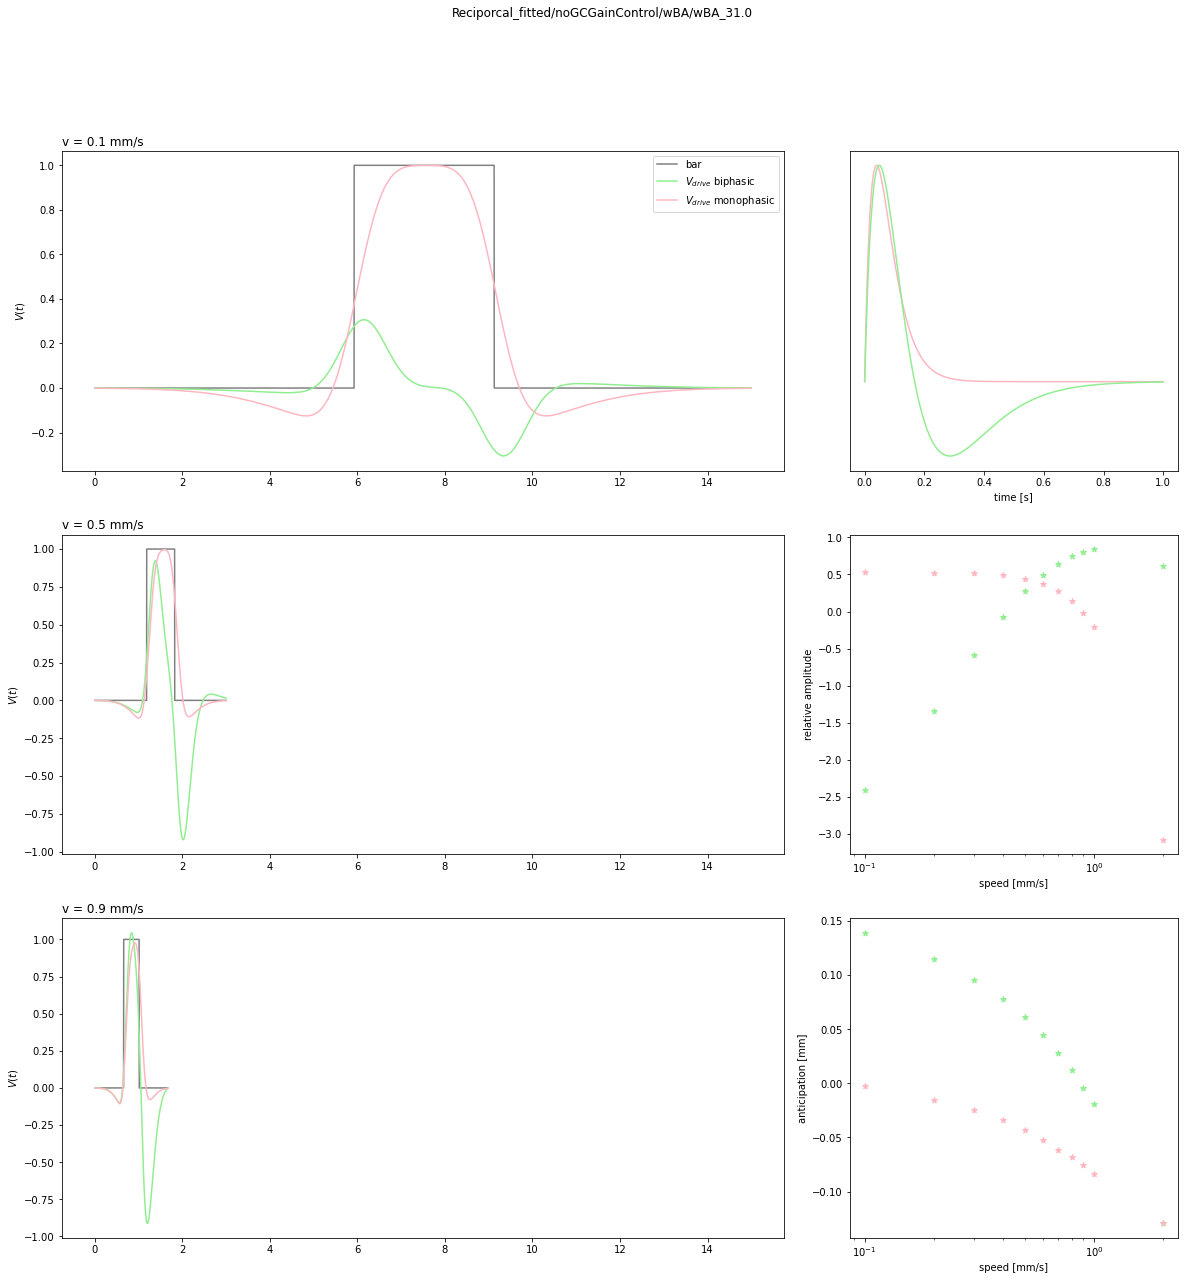

In [21]:
fig = plt.figure(figsize = (20,20))
gs = fig.add_gridspec(len(speeds_plot),3)



net = nets_list[0]
net_mono = nets_list[2]
for x,s in enumerate(speeds_plot):
    i = speeds_plot_idx[x]
    #title
    if i == 0:
        ax = fig.add_subplot(gs[x,:2])
    else:
        ax = fig.add_subplot(gs[x,:2], sharex = ax)
      
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    ax.plot(data['times'][i],data['bars'][i], label = f'bar', color = 'grey')

    # plot drive 
    ax.plot(data['times'][i],data[net]['F'][i]/np.max(data[net]['F'][-1]), label = '$V_{drive}$ biphasic', color = 'lightgreen')
    ax.plot(data['times'][i],data[net_mono]['F'][i]/np.max(data[net_mono]['F'][0]), label = '$V_{drive}$ monophasic', color = 'lightpink')

    # # plot RB
    # ax2.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB', color = 'blue')
    # ax2.plot(data['times'][i]*s,data[net_pool]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB without lateral connectivity', color = 'blue', linestyle = ':')
    # ax2.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')

    # plot RG
    #ax.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')
    if i ==0 :
        ax.legend()

    ax.set_ylabel('$V(t)$')
fig.suptitle(f'{net}')




fil = fig.add_subplot(gs[0,2])
fil.plot(ftime,filter_mono, color ='lightpink')
fil.plot(ftime,filter_bi, color ='lightgreen')
fil.set_xlabel('time [s]')
fil.set_yticks([])
amp = fig.add_subplot(gs[1,2])  
amp.scatter(speeds, normalize(data[net]['amps']['drive']),marker= '*',  color = 'lightgreen')
amp.scatter(speeds, normalize(data[net_mono]['amps']['drive']),marker= '*',  color = 'lightpink')
# amp.scatter(speeds, normalize(data[net]['amps']['RB']), color = 'blue')
# amp.scatter(speeds, normalize(data[net_mono]['amps']['RB']), color = 'red')
# amp.scatter(speeds, normalize(data[net]['amps']['RG']), color = 'green')
# amp.scatter(speeds, normalize(data[net_mono]['amps']['RG']), color = 'orange')
#amp.scatter(speeds, normalize(data[net]['amps']['RA']), color = 'red')
amp.set_xscale('log')
amp.set_xlabel('speed [mm/s]')
amp.set_ylabel('relative amplitude')


an = fig.add_subplot(gs[2,2])  
an.scatter(speeds, data[net]['ants']['drive']*speeds,marker= '*',  color = 'lightgreen')
an.scatter(speeds, data[net_mono]['ants']['drive']*speeds,marker= '*',  color = 'lightpink')
#an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'blue')
# an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'green')
# an.scatter(speeds, data[net_mono]['ants']['RG_bar']*speeds, color = 'orange')

an.set_xscale('log')
an.set_xlabel('speed [mm/s]')
an.set_ylabel('anticipation [mm]')